Automatic finetuning implementation test

In [1]:
PATH_PREFIX = '../../'
import sys
sys.path.append(PATH_PREFIX)

In [2]:
import torch
import torch.nn as nn
import os

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from data.utils.mnist_utils import *
from utils.quantize import *
from utils.weight_sharing import *
from utils.plot import *

In [3]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = 'cpu'
EPOCHS = 100

NET_PATH = os.path.join(PATH_PREFIX, 'models/lenet/saves/lenet_tanh.save')
SAVE_DATA = os.path.join(PATH_PREFIX, 'results/test_share.csv')

FOCUS_SEARCH_SPACE = np.arange(0, 10, 0.2)
FIXED_SPREAD = [2, 2, 2, 2, 2]
LAYER = [0, 1, 2, 3, 4]
SHARE_CLUSTERS = [15, 15, 6, 2, 2]
# tested tanh shares: [6, 17, 31, 4, 2], [3, 29, 2, 34, 4]

In [4]:
dataset = MnistDataset(BATCH_SIZE, os.path.join(PATH_PREFIX, 'data'), val_split=0.5)
model = LeNet5(N_CLASSES, 'tanh')
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

lam_test2 = lambda : get_accuracy(model, dataset.train_dl, DEVICE)
lam_test3 = lambda : get_accuracy(model, dataset.valid_dl, DEVICE)

ws_controller = WeightShare(model, lam_test, lam_opt, lam_train)
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


In [5]:
optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

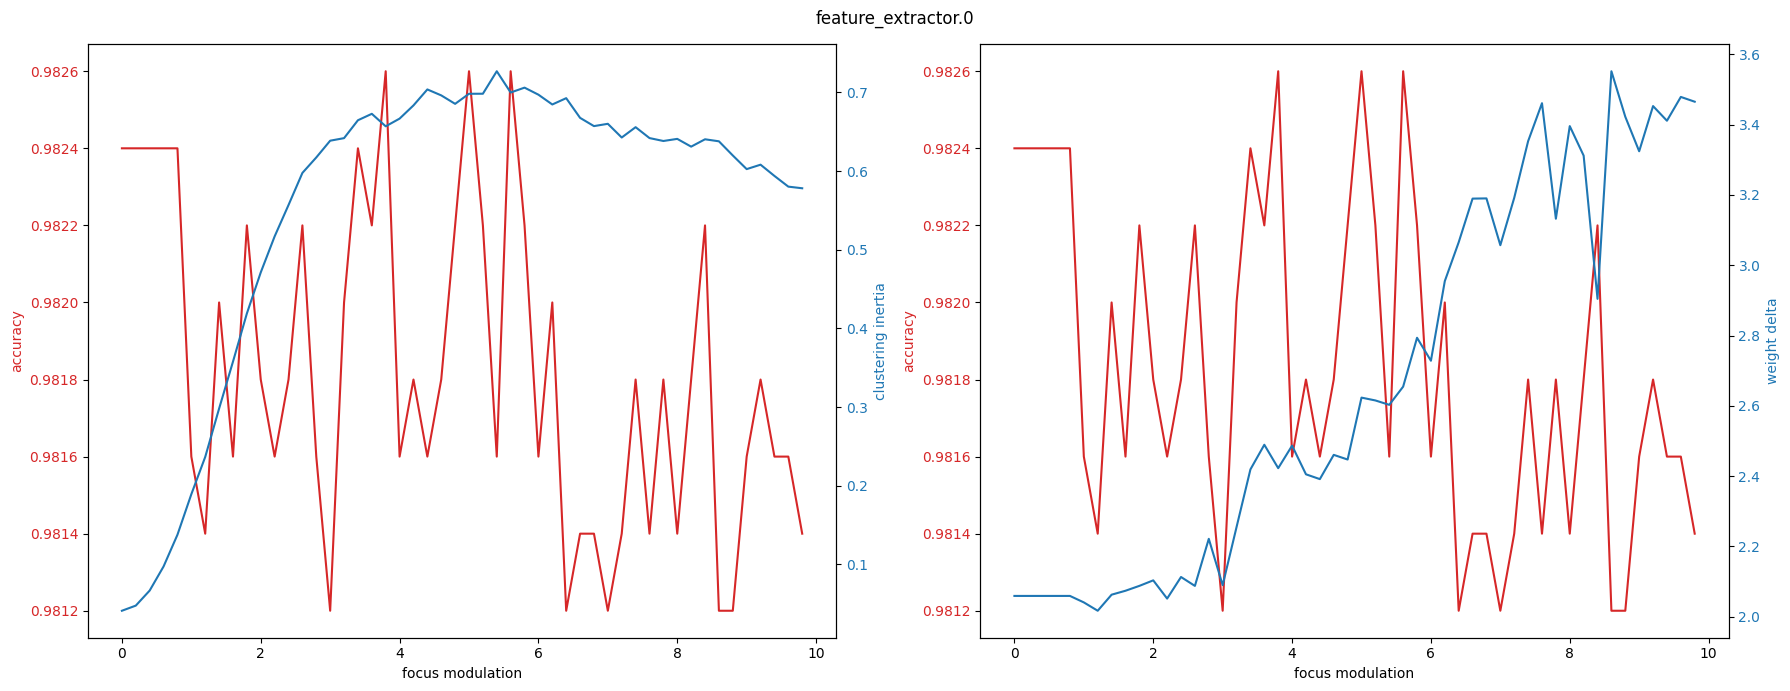

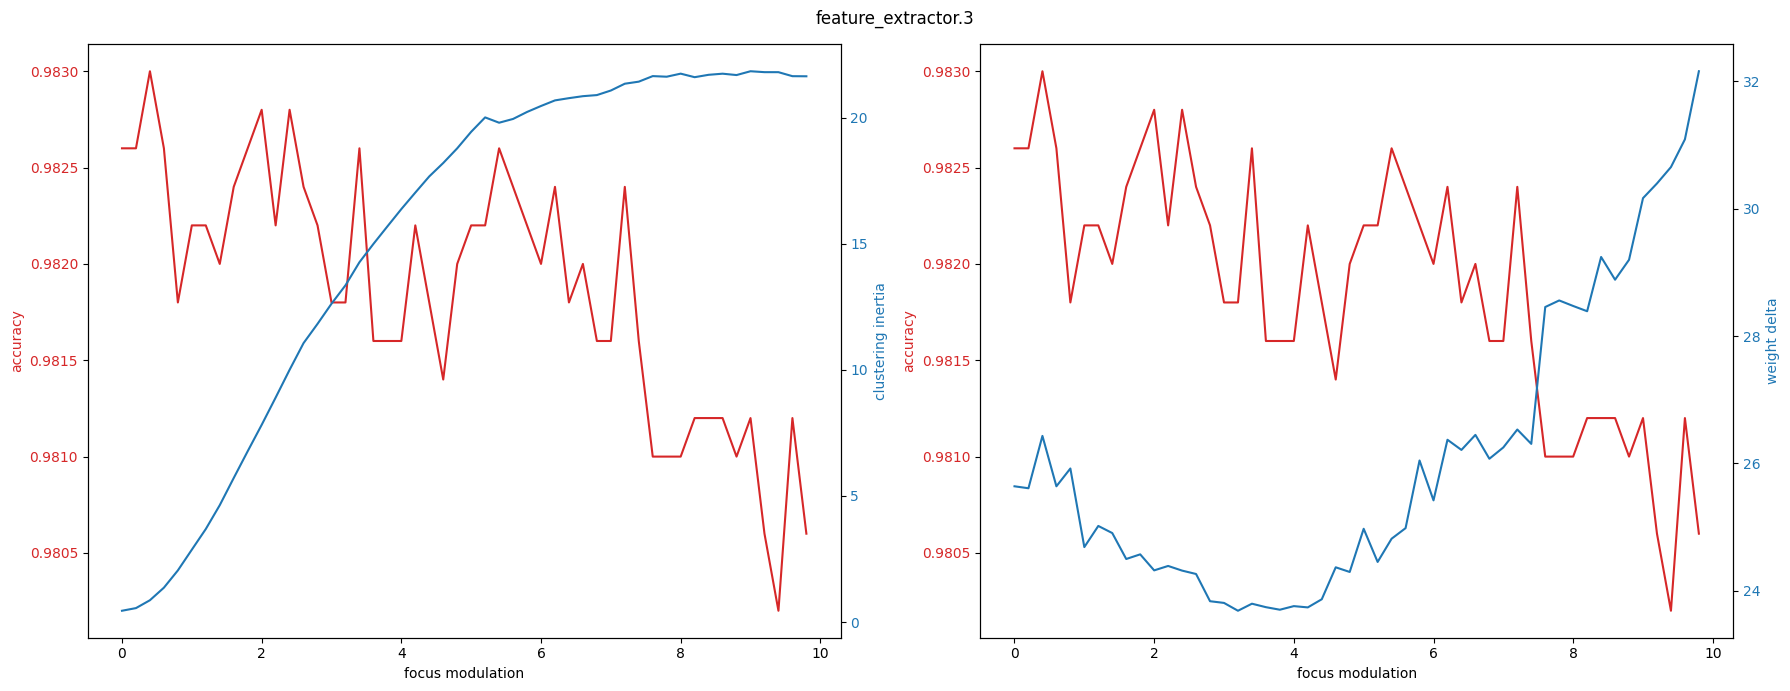

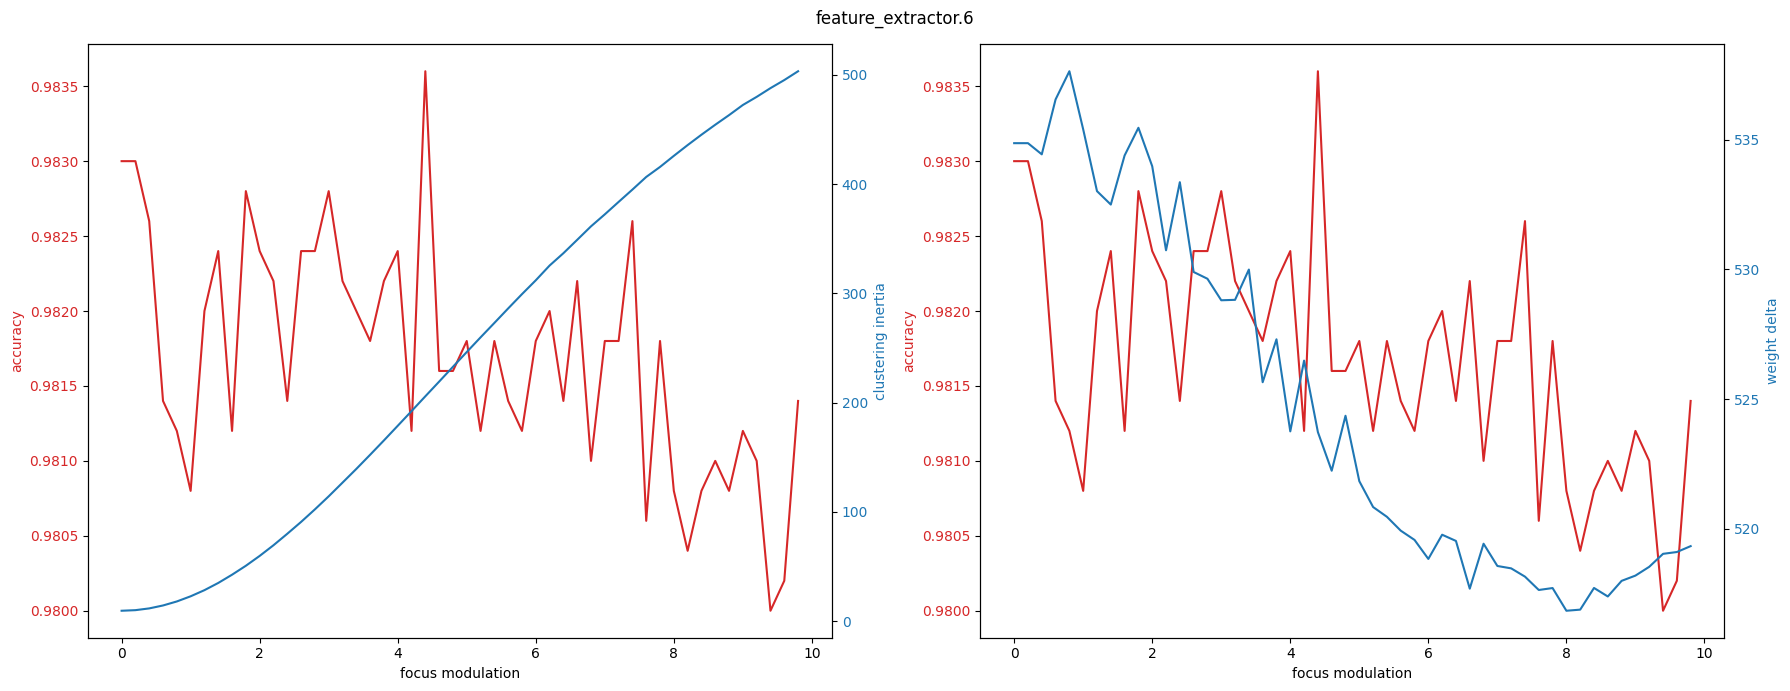

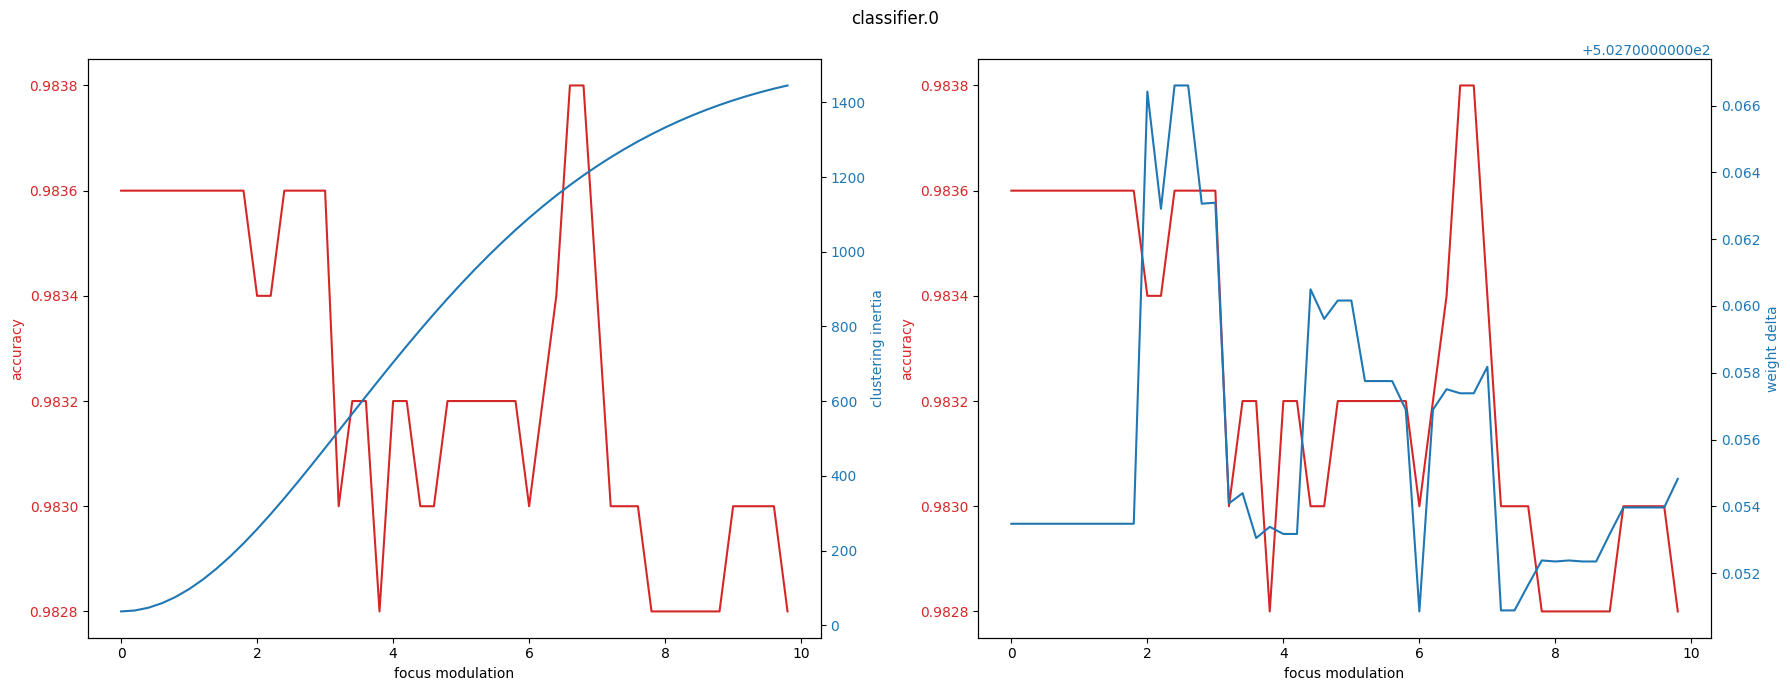

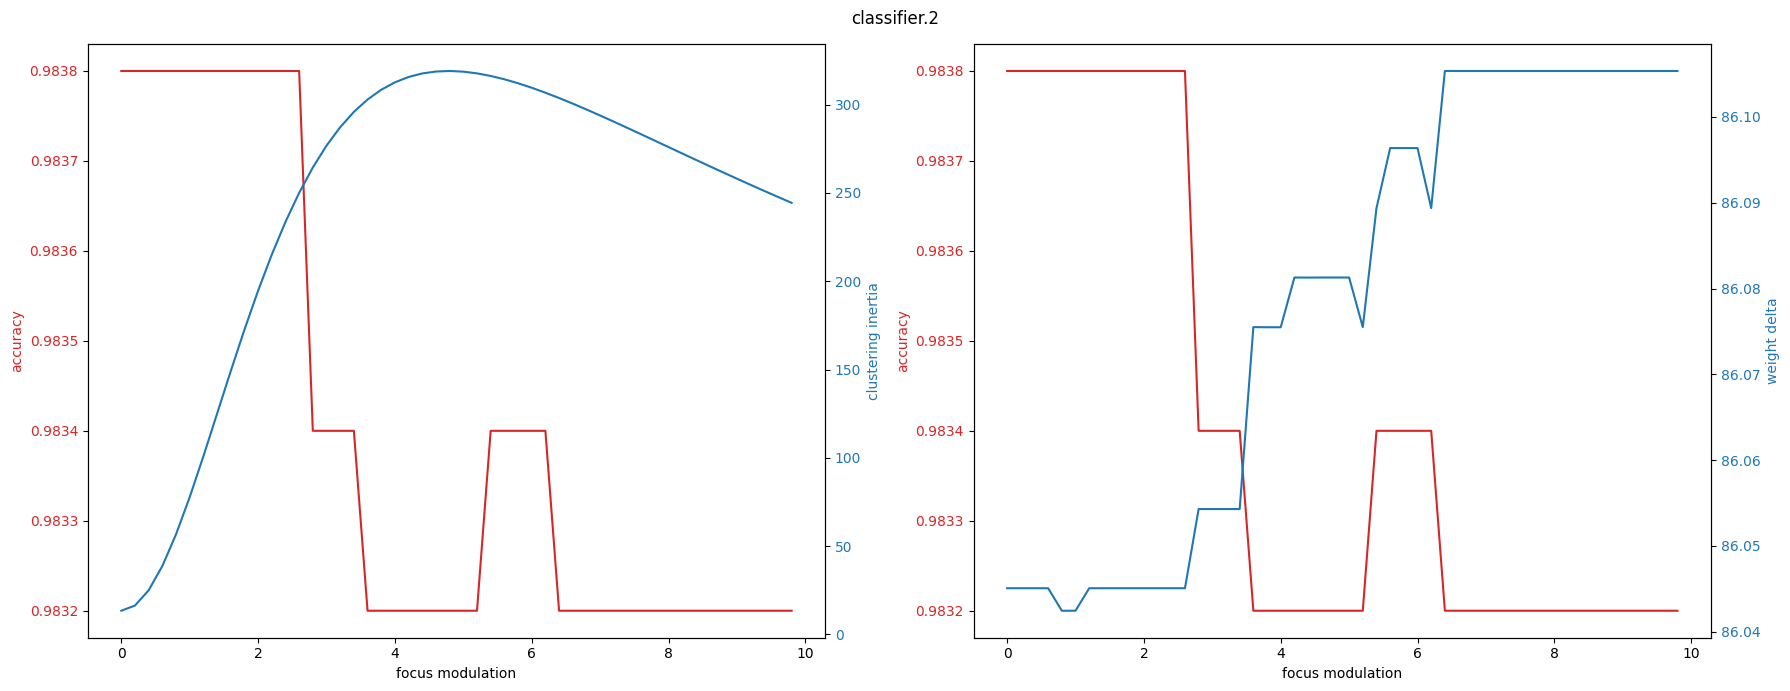

[3.8000000000000003, 0.4, 4.4, 6.6000000000000005, 0.0]

In [6]:
ws_controller.finetuned_mod(SHARE_CLUSTERS, FOCUS_SEARCH_SPACE, FIXED_SPREAD, LAYER, plot=True)

Finetuned  performance

In [7]:
ws_controller.test()

# finetuned relu lenet - 0.9782
# finetuned tanh lenet - 0.9868, 0.9808, 0.9838

0.9838

In [8]:
# train dataset test
lam_test2()

0.9918166666666667

In [9]:
# validation dataset test
lam_test3()

0.9854

Not finetuned performance

In [10]:
ws_controller.reset()

ws_controller.share(SHARE_CLUSTERS)

# not finetuned relu lenet - 0.9776
# not finetuned tanh lenet - 0.9854, 0.9794, 0.9824

{'accuracy': 0.9824,
 'compression': 16.779267579342225,
 'inertias': [0.041041627526283264,
  0.44914206862449646,
  9.57089614868164,
  37.053688049316406,
  13.429510116577148],
 'times': {'train': 0, 'share': 0.615309476852417, 'test': 0.8628382682800293}}

In [11]:
# train dataset test
lam_test2()

0.9918

In [12]:
# validation dataset test
lam_test3()

0.9864